[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_s2.ipynb)

#### based on Fig. S2 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import os
import numba

from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol_code import AerosolBoreal, AerosolMarine, AerosolNascent
from PySDM_examples.Lowe_et_al_2019.constants_def import LOWE_CONSTS
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.initialisation.spectra import Sum
from PySDM.physics import si, in_unit

import numpy as np
from joblib import Parallel, delayed, parallel_backend

from matplotlib import pyplot

In [3]:
CI = 'CI' in os.environ
nRes = 10
updraft_list = np.linspace(0.2, 2.4, 2 if CI else nRes)
models = ('Constant', 'CompressedFilmOvadnevaite')

FORMULAE = Formulae(constants=LOWE_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.Mv / FORMULAE.constants.rho_w
aerosols = (
    AerosolMarine(water_molar_volume=WATER_MOLAR_VOLUME), 
    AerosolBoreal(water_molar_volume=WATER_MOLAR_VOLUME), 
    AerosolNascent(water_molar_volume=WATER_MOLAR_VOLUME)
)

In [4]:
def compute(keyname, settings):
    simulation = Simulation(settings)
    out = simulation.run()
    out['updraft'] = settings.w
    out['org_fraction'] = settings.aerosol.modes[0]['f_org']
    out['color'] = settings.aerosol.color
    out['Na_tot'] = Sum(
            tuple(settings.aerosol.modes[i]['spectrum']
                  for i in range(len(settings.aerosol.modes)))).norm_factor
    return keyname, out

print(f'tasks scheduled: {len(models) * len(aerosols) * len(updraft_list)}')
print('updrafts:', updraft_list)
numba_original_num_threads = numba.get_num_threads()
numba.set_num_threads(1)
with parallel_backend(backend='loky', n_jobs=-2):
    output = dict(Parallel(verbose=0)(
        delayed(compute)(f"w{w:.2f}_{aerosol.__class__.__name__}_{model}", Settings(
            dz = 10 * si.m if CI else 1 * si.m,
            n_sd_per_mode = 10 if CI else 50,
            model = model,
            aerosol = aerosol,
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
        ))
        for w in updraft_list
        for model in models
        for aerosol in aerosols
    ))
numba.set_num_threads(numba_original_num_threads)

tasks scheduled: 12
updrafts: [0.2 2.4]


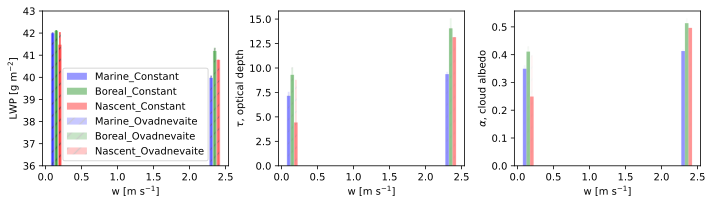

HTML(value="<a href='./tmpnlpdqzjs.pdf' target='_blank'>./tmpnlpdqzjs.pdf</a><br>")

In [5]:
fig, axes = pyplot.subplots(1, 3, figsize=(10,3))

optical_products = {}

for key, out_item in output.items():
    optical_products[key] = {}
    for prod in ('lwp', 'albedo', 'tau'):
        optical_products[key][prod] = out_item[prod]
    optical_products[key]["w"] = float(key.split("_", maxsplit=1)[0].split("w", maxsplit=1)[1])

for i,key in enumerate(output.keys()):
    ll = "_".join(key.split("_", maxsplit=1)[1:]).replace("Aerosol","").replace("CompressedFilm","")
    cc, disp = {
        "Marine": ("b", -0.1),
        "Boreal": ("g", -0.05),
        "Nascent": ("r", 0.0),
    }[ll.split("_", maxsplit=1)[0]]
    w, a, h = {
        "Constant": (0.05, 0.4, ""),
        "Ovadnevaite": (0.025, 0.6, "//"),
    }[ll.split("_", maxsplit=1)[1]]

    ax = axes[0]
    label = ll if key.split("_", maxsplit=1)[0] == "w0.20" else ''
    common_kwargs = {
        'color': cc,
        'width': w,
        'alpha': a,
        'hatch': h
    }

    ax.bar(
        optical_products[key]["w"] + disp,
        in_unit(optical_products[key]["lwp"], si.g / si.m**2),
        **common_kwargs, label=label
    )
    if label != '':
        ax.legend(loc = 0) #bbox_to_anchor=(5, 1))

    ax.set_xlabel("w [m s$^{-1}$]")
    ax.set_ylabel("LWP [g m$^{-2}$]")
    # ax.set_ylim(27,33)
    ax.set_ylim(36,43)

    ax = axes[1]
    ax.bar(optical_products[key]["w"] + disp, optical_products[key]["tau"], **common_kwargs)
    ax.set_xlabel("w [m s$^{-1}$]")
    ax.set_ylabel("$\\tau$, optical depth")

    ax = axes[2]
    ax.bar(optical_products[key]["w"] + disp, optical_products[key]["albedo"], **common_kwargs)
    ax.set_xlabel("w [m s$^{-1}$]")
    ax.set_ylabel("$\\alpha$, cloud albedo")

pyplot.tight_layout()
show_plot()